# Curvature Matrix error estimation

Please cite: V. C. Chmielewski and E. C. Bruning (2016), Lightning Mapping Array flash detection performance with variable receiver thresholds, J. Geophys. Res. Atmos., 121, 8600-8614, doi:10.1002/2016JD025159

If any results from this model are presented.

Contact:
vanna.chmielewski@noaa.gov

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import simulation_functions as sf
from mpl_toolkits.basemap import Basemap
from coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem

In [3]:
c0 = 3.0e8 # m/s
dt_rms = 23.e-9 # seconds

### Read in the network and set up coordinates

In [4]:
Network = 'grid_LMA' # Choose network from csv

stations = pd.read_csv('network.csv')
stations.set_index('network').loc[Network]
aves = np.array(stations.set_index('network').loc[Network])[:,:-1].astype('float')

center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])

alt, lat, lon  = aves[:,:3].T
stations_ecef  = np.array(geo.toECEF(lon, lat, alt)).T
stations_local = tanp.toLocal(stations_ecef.T).T
ordered_threshs = aves[:,-1]

### Set up the grid of source points

In [5]:
xmin, xmax, xint = -200001, 199999, 5000 # Extent of grid (km)
alts = np.array([7000])

initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(xmin,xmax+xint,xint), alts))

points = initial_points.reshape(3,int(np.size(initial_points)/3)).T

### Set source power and run the curvature matrix math

In [6]:
# power = 0.84 # 98% FDE or OK/COLMA 95% in Watts
# power = 1.57 # NALMA 95%
# power = 1.36  # 95% FDE
# power = 2.67  # 90% FDE
# power = 4.34 # 85% FDE
# power = 6.79 # 80% FDE
power = 9.91  # 75% FDE
# power = 14.00 # 70% FDE
# power = 10000  # High powered source for full station contribution in domain

means = np.empty((np.shape(points)[0],4))
for i in range(np.shape(points)[0]): 
    means[i] = sf.curvature_matrix(points[i],stations_local,ordered_threshs,c0,power=power,timing_error=dt_rms,min_stations=6)
    
means = means.T.reshape((4,np.shape(initial_points)[1],np.shape(initial_points)[2]))
means  = np.ma.masked_where(np.isnan(means) , means)

/localdata/LMAsimulation/simulation_functions.py:483: RuntimeWarning: invalid value encountered in sqrt
  (c0*c0*timing_error*timing_error)))**0.5


### Plotting

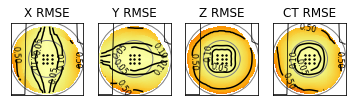

In [7]:
fig = plt.figure()

ax1 = fig.add_subplot(141)
sf.nice_plot(means[0,:,:]/1000.,xmin,xmax,xint,
             center[0],center[1],stations_local,color='inferno_r',cmin=0,cmax=3,levels_t=(0.05,0.1,0.5,1,5))
plt.title('X RMSE')
ax2 = fig.add_subplot(142)
sf.nice_plot(means[1,:,:]/1000.,xmin,xmax,xint,
             center[0],center[1],stations_local,color='inferno_r',cmin=0,cmax=3,levels_t=(0.05,0.1,0.5,1,5))
plt.title('Y RMSE')
ax3 = fig.add_subplot(143)
sf.nice_plot(means[2,:,:]/1000.,xmin,xmax,xint,
             center[0],center[1],stations_local,color='inferno_r',cmin=0,cmax=3,levels_t=(0.05,0.1,0.5,1,5))
plt.title('Z RMSE')
ax4 = fig.add_subplot(144)
sf.nice_plot(means[3,:,:]/1000.,xmin,xmax,xint,
             center[0],center[1],stations_local,color='inferno_r',cmin=0,cmax=3,levels_t=(0.05,0.1,0.5,1,5))
plt.title('CT RMSE')

plt.show()

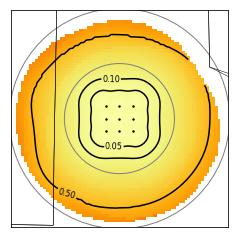

In [8]:
sf.nice_plot(means[2,:,:]/1000.,xmin,xmax,xint,
             center[0],center[1],stations_local,color='inferno_r',cmin=0,cmax=3,levels_t=(0.05,0.1,0.5,1,5))